<a href="https://colab.research.google.com/github/Yohk2291/MachineLearning/blob/master/objectdetection/2_1_SSD_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/Yohk2291/MachineLearning.git
%cd MachineLearning/
%cd objectdetection/

Cloning into 'MachineLearning'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 89 (delta 33), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (89/89), done.
/content/MachineLearning/objectdetection/MachineLearning/objectdetection/MachineLearning
/content/MachineLearning/objectdetection/MachineLearning/objectdetection/MachineLearning/objectdetection


In [0]:
import os
import urllib.request
import zipfile
import tarfile

In [0]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [0]:
# フォルダ「weights」が存在しない場合は作成する
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [0]:
# VOC2012のデータセットをダウンロード
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    tar = tarfile.TarFile(target_path)  # tarファイルを読み込み
    tar.extractall(data_dir)  # tarを解凍
    tar.close()  # tarファイルをクローズ

In [0]:
# 学習済みのSSD用のVGGのパラメータをフォルダ「weights」にダウンロード
# MIT License
# Copyright (c) 2017 Max deGroot, Ellis Brown
# https://github.com/amdegroot/ssd.pytorch
    
url = "https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth"
target_path = os.path.join(weights_dir, "vgg16_reducedfc.pth") 

if not os.path.exists(target_path):
  urllib.request.urlretrieve(url, target_path)

In [0]:
# 学習済みのSSD300モデルをフォルダ「weights」にダウンロード
# MIT License
# Copyright (c) 2017 Max deGroot, Ellis Brown
# https://github.com/amdegroot/ssd.pytorch

url = "https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth"
target_path = os.path.join(weights_dir, "ssd300_mAP_77.43_v2.pth") 

if not os.path.exists(target_path):
  urllib.request.urlretrieve(url, target_path)

## 各種パッケージのインポート

In [0]:
# パッケージのimport
import os.path as osp
import random
# XMLをファイルやテキストから読み込んだり、加工したり、保存したりするためのライブラリ
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms


In [0]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [0]:
print("PyTorch Version", torch.__version__)
print("Torchvision Version", torchvision.__version__)

PyTorch Version 1.1.0
Torchvision Version 0.3.0


## 画像データ、アノテーションデータへのファイルパスのリスト作成

In [0]:
def make_datapath_list(rootpath):
  # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
  imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
  annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')
  
  # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
  train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
  val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

  # 訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
  train_img_list = list()
  train_anno_list = list()

  for line in open(train_id_names):
    file_id = line.strip() # 空白スペースと改行を除去
    img_path = (imgpath_template % file_id) # 画像のパス
    anno_path = (annopath_template % file_id) # アノテーションのパス
    train_img_list.append(img_path) # リストに追加
    train_anno_list.append(anno_path) # リストに追加


  # 検証データの画像ファイルとアノテーションファイルへのパスリストを作成
  val_img_list = list()
  val_anno_list = list()

  for line in open(val_id_names):
    file_id = line.strip() # 空白スペースと改行を除去
    img_path = (imgpath_template % file_id) # 画像のパス
    anno_path = (annopath_template % file_id) # アノテーションのパス
    val_img_list.append(img_path) # リストに追加
    val_anno_list.append(anno_path) # リストに追加

  
  return train_img_list, train_anno_list, val_img_list, val_anno_list


In [0]:
# 動作確認
rootpath = "./data/VOCdevkit/VOC2012/"

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

print(train_img_list[0])
print(train_anno_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg
./data/VOCdevkit/VOC2012/Annotations/2008_000008.xml


## アノテーションデータをxml形式からリストへ変換

In [0]:
class Anno_xml2list(object):

  def __init__(self, classes):
    self.classes = classes

  def __call__(self, xml_path, width, height):
    
    ret = []

    # xmlファイルを読み込む
    xml = ET.parse(xml_path).getroot()

    # 画像内のobjectの数だけループ
    for obj in xml.iter('object'):

      # アノテーションで検知がdifficultに設定(1と表示)されているものは除外
      difficult = int(obj.find('difficult').text)
      if difficult == 1:
        continue
      
      # １つの物体に対するアノテーションを格納するリスト
      bndbox = []

      name = obj.find('name').text.lower().strip() # 物体名（小文字にして空白・改行除去）
      bbox = obj.find('bndbox') # バウンディングボックスの情報

      # アノテーションのxmin, ymin, xmax, ymaxを取得し、0~1に規格化
      pts = ['xmin', 'ymin', 'xmax', 'ymax']

      for pt in (pts):
        # VOCは原点が(1, 1)なので、1を引いて(0, 0)にする
        cur_pixel = int(bbox.find(pt).text) - 1

        # 幅、高さで規格化
        if pt == 'xmin' or 'xmax': # x方向の時は幅(width)で割る
          cur_pixel /= width

        else: # y方向の時は高さ(height)で割る
          cur_pixel /= height

        bndbox.append(cur_pixel)

      
      label_idx = self.classes.index(name)
      bndbox.append(label_idx)

      # ret に[xmin, ymin, xmax, ymax, label_idx]を足す
      ret += [bndbox]

    return np.array(ret)


In [0]:
# 動作確認
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path) # OpenCVを使用して指定した画像を読み込む
height, width, channels = img.shape

# アノテーションをリストで表示[xmin, ymin, xmax, ymax, label_idx]
transform_anno(val_anno_list[ind], width, height)

array([[ 0.09 ,  0.02 ,  0.998,  0.664, 18.   ],
       [ 0.122,  0.378,  0.164,  0.484, 14.   ]])

## 画像とアノテーションの前処理を行うクラスDataTransformを作成

In [0]:
# utils内のdata_augumentation.py から import
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans

In [0]:
class DataTransform():

  def __init__(self, input_size, color_mean):
    self.data_transform = {
        'train' : Compose([
                ConvertFromInts(), # intをfloat32に変換
                ToAbsoluteCoords(), # アノテーションデータの規格化を戻す
                PhotometricDistort(), # 画像の色調等をランダムに変化
                Expand(color_mean), # 画像のキャンバスを広げる
                RandomSampleCrop(), # 画像内の部分をランダムに抜き出す
                RandomMirror(), # 画像をランダムに反転させる
                ToPercentCoords(), # アノテーションデータを0-1に規格化                      
                Resize(input_size), # 画像サイズを input_size * input_size に変形
                SubtractMeans(color_mean) # BGRの色の平均値を引き算
                ]),
        'val' : Compose([
                ConvertFromInts(), # intをfloat32に変換                     
                Resize(input_size), # 画像サイズを input_size * input_size に変形
                SubtractMeans(color_mean) # BGRの色の平均値を引き算
                ])
    }

  def __call__(self, img, phase, boxes, labels):

    return self.data_transform[phase](img, boxes, labels)

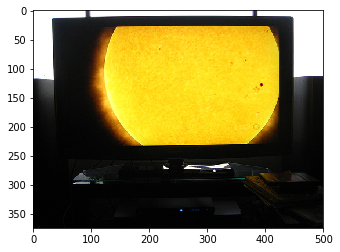

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


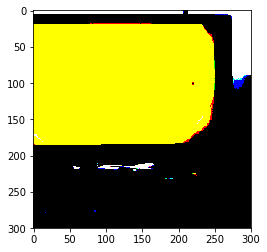

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


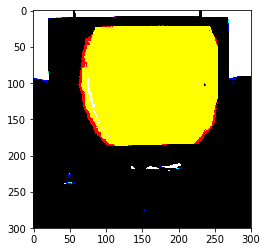

In [0]:
# 動作確認

# 1.画像読み込み
image_file_path = val_img_list[0]
img = cv2.imread(image_file_path) # OpenCVを使用して指定した画像を読み込む
height, width, channels = img.shape

# 2.アノテーションをリストに
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(val_anno_list[0], width, height)

# 3.元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4.前処理クラスの作成
color_mean = (104, 117, 123) # (BGR)の色の平均値
input_size = 300 # 画像の input size を300にする
transform = DataTransform(input_size, color_mean)

# 5.train画像の表示
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

# 6.val画像の表示
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

## Datasetの作成

In [0]:
# VOC2012のデータセットを作成する

class VOCDataset(data.Dataset):

  def __init__(self, img_list, anno_list, phase, transform, transform_anno):
    self.img_list = img_list
    self.anno_list = anno_list
    self.phase = phase
    self.transform = transform
    self.transform_anno = transform_anno

  def __len__(self): # 画像の枚数を返す
    return len(self.img_list)

  def __getitem__(self, index): # 前処理をした画像のテンソル形式のデータとアノテーションを取得
    im, gt, h, w = self.pull_item(index)
    return im, gt

  def pull_item(self, index):

    # 1.画像読み込み
    image_file_path = self.img_list[index]
    img = cv2.imread(image_file_path) # OpenCVを使用して指定した画像を読み込む
    height, width, channels = img.shape
    
    # 2.アノテーションをリストに
    anno_file_path = self.anno_list[index]
    anno_list = self.transform_anno(anno_file_path, width, height)
    
    # 3.前処理を実施
    img, boxes, labels = transform(
        img, self.phase, anno_list[:, :4], anno_list[:, 4])
    
    # BGR->RGB、(h, w, c)->(c, h, w)に変更
    img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

    # BBoxとラベルをセットにしたnp.arrayを作成(gt:ground truth)
    gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

    return img, gt, height, width


In [0]:
# 動作確認
color_mean = (104, 117, 123) # (BGR)の色の平均値
input_size = 300 # 画像の input size を300にする

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", 
                           transform=DataTransform(input_size, color_mean), 
                           transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", 
                         transform=DataTransform(input_size, color_mean), 
                         transform_anno=Anno_xml2list(voc_classes))

val_dataset.__getitem__(1)

(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9082,  -13.2200,
             -9.4034],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9501,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2816,  -20.1750,   -5.5633,  ..., -104.9934, -111.8350,
           -119.0000],
          [ -20.4766,  -21.0000,  -12.6334,  ..., -107.1685, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0766,  -14.7250,
            -11.8534],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5016,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9501,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

## DataLoaderを作成

In [0]:
def od_collate_fn(batch):

  targets = []
  imgs = []
  for sample in batch:
    imgs.append(sample[0])
    targets.append(torch.FloatTensor(sample[1]))

  # imgs:(c, w, h)->(b, c, w, h)
  imgs = torch.stack(imgs, dim=0) 

  # targets:(n, 5) 
  # n:画像内の物体数(画像毎に異なる)、5:[xmin, ymin, xmax, ymax, class_index]

  return imgs, targets

In [0]:
# ミニバッチのサイズ
batch_size = 4

# DataLoaderの作成
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


# 動作確認
batch_iterator = iter(dataloaders_dict["val"])
images, targets = next(batch_iterator)

print(images.size()) #(b, c, w, h)
print(len(targets)) 
print(targets[1].size()) # (n, 5)

torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


In [0]:
print(train_dataset.__len__())
print(val_dataset.__len__())

5717
5823


以下作成中・・・・・

## ネットワークモデルの作成

## 損失関数を定義

## 最適化手法の設定

## 学習・検証